# Classification. Linear models and KNN

In [93]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [94]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

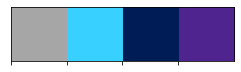

In [4]:
colors = ['#a6a6a6','#38d1ff','#001c57','#50248f']
sns.palplot(sns.color_palette(colors))

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [5]:
data = pd.read_csv(  './titanic/train.csv').set_index('PassengerId')
test=pd.read_csv(  './titanic/test.csv').set_index('PassengerId')

In [6]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

#### Analyze male and females

In [7]:
dataSex=pd.concat((data.Sex.value_counts()/data.shape[0],data.Sex.value_counts()),axis=1)
dataSex.columns=["percent",'count']
dataSex

,percent,count
male,0.647587,577
female,0.352413,314


In [8]:
dataSurvived=pd.concat((data.Survived.value_counts()/data.shape[0],data.Survived.value_counts()),axis=1)
dataSurvived.columns=["percent",'count']
dataSurvived

,percent,count
0,0.616162,549
1,0.383838,342


C:\Users\gabar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Relationship between the gender and the survival')

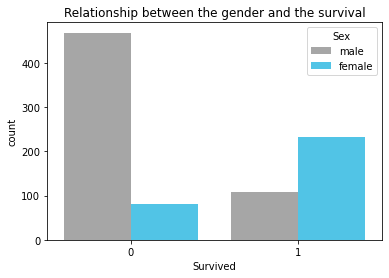

In [9]:
sns.countplot(data.Survived, hue=data.Sex,palette=colors).set_title("Relationship between the gender and the survival")

In [10]:
data_crosstab = pd.crosstab(data['Sex'], 
                            data['Survived'],  
                               margins = False) 
data_crosstab

Survived,0,1
Sex,,
female,81,233
male,468,109


**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

C:\Users\gabar\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


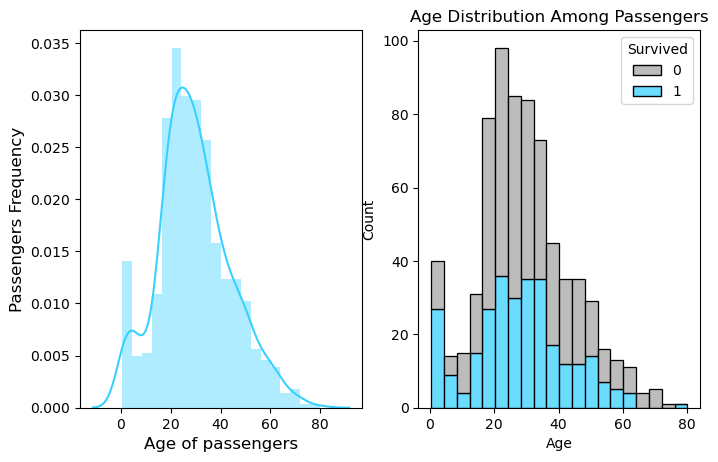

In [11]:
# Create a stacked histogram to show survival by age.
f,( ax1,ax2) = plt.subplots(ncols=2,figsize=(8, 5),dpi=100)
sns.histplot(x=data.Age,hue=data.Survived, multiple="stack",palette=colors[:2],ax=ax2)
fig= sns.distplot(data.Age, color= colors[1],ax=ax1)
fig.set_xlabel("Age of passengers",size=12)
fig.set_ylabel("Passengers Frequency",size=12)
plt.title('Age Distribution Among Passengers',size = 12)
plt.show()


In [12]:
data.Age.isna().value_counts()

False    714
True     177
Name: Age, dtype: int64

In [13]:
data.groupby("Survived")["Age"].describe()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,424.0,30.626179,14.172110,1.00,21.0,28.0,39.0,74.0
1,290.0,28.343690,14.950952,0.42,19.0,28.0,36.0,80.0


In [14]:
data["Age"].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

Средний возраст погибшего - 30 , медиана - 28. Выжившего среднее- 28, медиана -28. Как таковой большой разницы в среднем и медиане нету. Наше распределение возраста немного positive skewed. Распределение выживших больше выглядет как нормальное распределение , поэтому медиана и среднее совпадает. Соответсвенно вероятность выжить повышается в районе среднее +- 2 std. 
Но в то же время довольно много значениеепропущенно 177( 177/ (177+714) = 20 %), 20% от всего кол-ва. Это достаточно большой процент. Эти данные можно попытаться заполнить.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

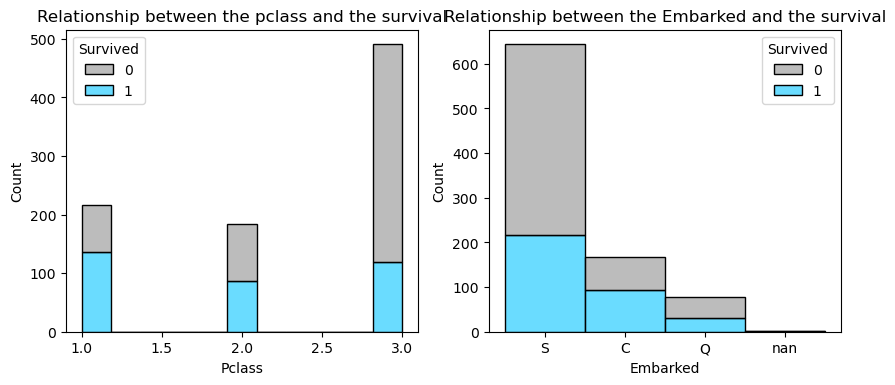

In [15]:
# Create a stacked histogram to show survival by age.
f,( ax1,ax2) = plt.subplots(ncols=2,figsize=(10, 4),dpi=100)
sns.histplot(x=data.Pclass,hue=data.Survived, multiple="stack",palette=colors[:2],ax=ax1).set_title("Relationship between the pclass and the survival")
sns.histplot(x=data.Embarked.astype(str),hue=data.Survived, multiple="stack",palette=colors[:2],ax=ax2).set_title("Relationship between the Embarked and the survival")

plt.show()

In [16]:
data_pclass=(data.groupby(['Survived'])['Pclass']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('Pclass'))
data_pclass

,Survived,Pclass,percentage
2,0,1,14.571949
3,1,1,39.766082
1,0,2,17.668488
5,1,2,25.438596
0,0,3,67.759563
4,1,3,34.795322


In [17]:
data_Embarked=(data.groupby(['Survived'])['Embarked']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('Embarked'))
data_Embarked

,Survived,Embarked,percentage
1,0,C,13.661202
4,1,C,27.352941
2,0,Q,8.561020
5,1,Q,8.823529
0,0,S,77.777778
3,1,S,63.823529


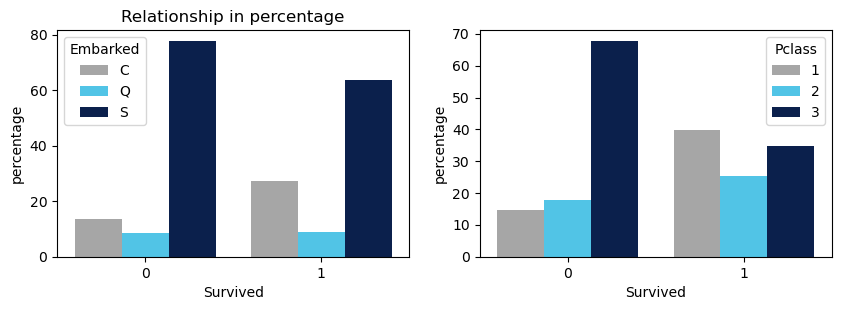

In [18]:
f,( ax1,ax2) = plt.subplots(ncols=2,figsize=(10, 3),dpi=100)
sns.barplot(x="Survived", y="percentage",hue="Embarked", data=data_Embarked,ax=ax1,palette=colors).set_title("Relationship in percentage")
sns.barplot(x="Survived", y="percentage",hue="Pclass",data=data_pclass, ax=ax2, palette=colors)
plt.show()

Explore "passenger class" and "embarked" features. What class was "the safest"?
Вероятность выжить в 1 классе почти 40%, во втором классе 25%, а в третьем классе 35%. Соответственно самый безопасный это 1 класс. 


 Is there any relationship between the embarkation port and the survival?
Да есть связь. Процент выживших в порте S 78 % . Почему? Возможно это наиболее популярный порт.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [19]:
(data.isna().sum()/data.shape[0]*100).sort_values()

Survived     0.000000
Pclass       0.000000
Name         0.000000
Sex          0.000000
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
Embarked     0.224467
Age         19.865320
Cabin       77.104377
dtype: float64

In [20]:
(test.isna().sum()/test.shape[0]*100).sort_values()

Pclass       0.000000
Name         0.000000
Sex          0.000000
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Embarked     0.000000
Fare         0.239234
Age         20.574163
Cabin       78.229665
dtype: float64

In [21]:
data["Embarked"].fillna("S",inplace=True)

In [22]:
data.drop(["Cabin"],axis=1,inplace=True)
test.drop(["Cabin"],axis=1,inplace=True)

In [23]:
all_data=pd.concat([data.drop(["Survived"],axis=1),test])

In [24]:
all_data["Name_extract"]=all_data['Name'].str.extract('([A-Za-z]+)\.')

In [25]:
all_data["Age_extract"]=0
for index, row in all_data.iterrows():
    all_data.loc[index,"Age_extract"]=all_data[all_data["Name_extract"]==row['Name_extract']]["Age"].mean()
all_data["Age"].fillna(all_data["Age_extract"],inplace=True)    

In [26]:
test["Fare"].fillna(all_data[(all_data["Pclass"]==3)&(all_data["Name_extract"]=="Mr")]["Fare"].mean(),inplace=True)

In [27]:
data=pd.concat([all_data[["Age_extract","Name_extract"]], data],  join="inner",axis=1)
test=pd.concat([all_data[["Age_extract","Name_extract"]], test],  join="inner",axis=1)

In [28]:
data["Age"].fillna(data["Age_extract"],inplace=True)
test["Age"].fillna(test["Age_extract"],inplace=True)

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

в Embarked  пропущено всего два значения, так как распределение признаков между S,C,Q не равномерное, можно эти два значения заменить наиболее популярным значением S. Поле Cabin Пропущенных значений 77%, в данном случае мне кажется проще удалить данную характеристику.  По характеристики Age, предлагаю посмотреть на нижние графики. Если рассмотреть имя то там есть приставка Mr, Mrs, Sir - которая может харакеризовать возраст. Можно взять среднее значение по данному титулу и сделать замену в Age.

C:\Users\gabar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


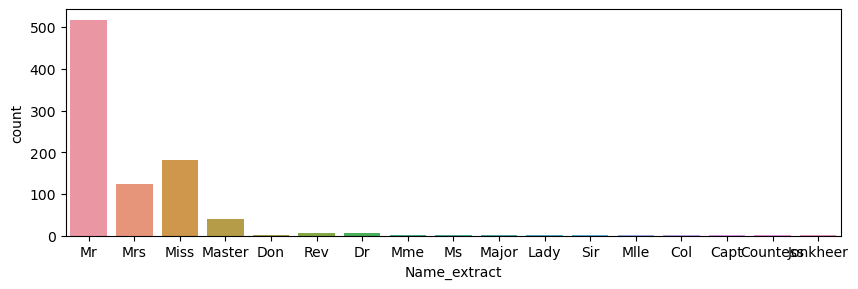

In [29]:

f,_ = plt.subplots(figsize=(10, 3),dpi=100)

sns.countplot(data["Name_extract"])

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [30]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

In [31]:
y = data['Survived']
X_train = data.drop([  'Survived',  'Name',  'Ticket'], 1)  
y_train = data['Survived']
X_test = test.drop(    [ 'Name', 'Ticket'], 1)
X_train.Pclass=X_train.Pclass.astype('category')
X_test.Pclass=X_test.Pclass.astype('category')

In [32]:
X_train_dumies=pd.get_dummies(X_train[["Sex","Embarked","Pclass"]])
X_test_dumies=pd.get_dummies(X_test[["Sex","Embarked","Pclass"]])
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[["Age","SibSp","Parch","Fare"]])
X_test_scaled = scaler.fit_transform(X_test[["Age","SibSp","Parch","Fare"]])
X=np.concatenate((X_train_scaled, X_train_dumies.values), axis=1)
X_test_new= np.concatenate((X_test_scaled, X_test_dumies.values), axis=1)

In [33]:
logreg = LogisticRegression(max_iter=10000, random_state=0)
print(np.mean(cross_val_score(logreg,X,y_train,cv=5,scoring="accuracy") ))

0.7946393823363254


In [34]:
neigh = KNeighborsClassifier(n_neighbors=8)
print(np.mean(cross_val_score(neigh,X,y_train,cv=5,scoring="accuracy") ))

0.8080597577051034


In [35]:
neigh.fit(X,y_train)
res_neigh=neigh.predict(X_test_new)
submission_neigh = pd.DataFrame({'PassengerId':test.index,'Survived':res_neigh})
submission_neigh.to_csv("res_neiht.csv",index=False)

logreg.fit(X,y_train)
res_logreg=logreg.predict(X_test_new)
submission_logreg = pd.DataFrame({'PassengerId':test.index,'Survived':res_logreg})
submission_logreg.to_csv("res_logreg.csv",index=False)

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [36]:
df=[data,test]

In [37]:
for dataset in df:
    dataset["relatives"]=dataset["SibSp"]+dataset["Parch"]
    dataset.loc[dataset["relatives"]>0,"not_alone"]=0
    dataset.loc[dataset["relatives"]==0,"not_alone"]=1
    dataset['not_alone'] = dataset['not_alone'].astype(int)

In [38]:
data['Name_extract'].replace('Dr', 'Mr', inplace=True)
data['Name_extract'].replace('Rev', 'Mr', inplace=True)
data['Name_extract'].replace('Major', 'Mr', inplace=True)
data['Name_extract'].replace('Col', 'Mr', inplace=True)
data['Name_extract'].replace('Mlle', 'Miss', inplace=True)
data['Name_extract'].replace('Mme', 'Mrs', inplace=True)
data['Name_extract'].replace('Capt', 'Mr', inplace=True)
data['Name_extract'].replace('Countess', 'Mrs', inplace=True)
data['Name_extract'].replace('Ms', 'Miss', inplace=True)
data['Name_extract'].replace('Sir', 'Mr', inplace=True)
data['Name_extract'].replace('Jonkheer', 'Mr', inplace=True)
data['Name_extract'].replace('Don', 'Mr', inplace=True)
data['Name_extract'].replace('Dona', 'Mrs', inplace=True)
data['Name_extract'].replace('Lady', 'Mrs', inplace=True)

In [39]:
test['Name_extract'].replace('Dr', 'Mr', inplace=True)
test['Name_extract'].replace('Rev', 'Mr', inplace=True)
test['Name_extract'].replace('Major', 'Mr', inplace=True)
test['Name_extract'].replace('Col', 'Mr', inplace=True)
test['Name_extract'].replace('Mlle', 'Miss', inplace=True)
test['Name_extract'].replace('Mme', 'Mrs', inplace=True)
test['Name_extract'].replace('Capt', 'Mr', inplace=True)
test['Name_extract'].replace('Countess', 'Mrs', inplace=True)
test['Name_extract'].replace('Ms', 'Miss', inplace=True)
test['Name_extract'].replace('Sir', 'Mr', inplace=True)
test['Name_extract'].replace('Jonkheer', 'Mr', inplace=True)
test['Name_extract'].replace('Don', 'Mr', inplace=True)
test['Name_extract'].replace('Dona', 'Mrs', inplace=True)
test['Name_extract'].replace('Lady', 'Mrs', inplace=True)

In [40]:
for dataset in df:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

In [41]:
for dataset in df:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

In [42]:
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4}
ports = {"S": 0, "C": 1, "Q": 2}
genders = {"male": 0, "female": 1}
for dataset in df:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)
    dataset['Age_Class']= dataset['Age']* dataset['Pclass']
    dataset["Name_title"]=dataset.Name_extract.map(titles)
    dataset['Embarked'] = dataset['Embarked'].map(ports)
    dataset['Sex'] = dataset['Sex'].map(genders)

In [43]:
data_kaggle=data[["Pclass","Sex","Age","SibSp","Parch","Fare","Embarked","relatives","not_alone","Fare_Per_Person","Age_Class","Name_title"]]
data_kaggle

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Fare_Per_Person,Age_Class,Name_title
PassengerId,,,,,,,,,,,,
1,3,0,2,1,0,0,0,1,0,0,6,1
2,1,1,5,1,0,3,1,1,0,1,5,3
3,3,1,3,0,0,1,0,0,1,1,9,2
4,1,1,5,1,0,3,0,1,0,1,5,3
5,3,0,5,0,0,1,0,0,1,1,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...
887,2,0,3,0,0,1,0,0,1,1,6,1
888,1,1,2,0,0,2,0,0,1,2,2,2
889,3,1,2,1,2,2,0,3,0,0,6,2


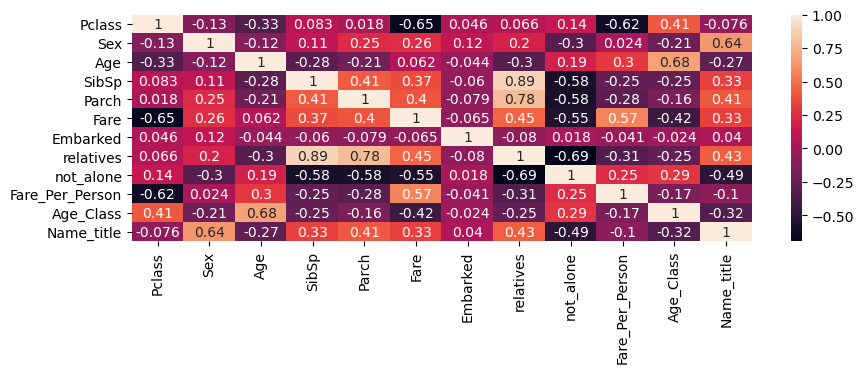

In [44]:
f,_ = plt.subplots(figsize=(10, 3),dpi=100)
sns.heatmap(data_kaggle.corr(),annot=True)

In [45]:
y = data['Survived']
test_kaggle=test[["Pclass","Sex","Age","SibSp","Parch","Fare","Embarked","relatives","not_alone","Fare_Per_Person","Age_Class","Name_title"]]


In [46]:
logreg = LogisticRegression()

logreg.fit(data_kaggle,y)
res_logreg=logreg.predict(test_kaggle)
submission_logreg = pd.DataFrame({'PassengerId':test.index,'Survived':res_logreg})
submission_logreg.to_csv("res_logreg6.csv",index=False)

In [47]:
np.mean(cross_val_score(logreg,data_kaggle,y, scoring="accuracy"))

0.8260561170045821

In [48]:
logreg = LogisticRegression(solver="liblinear",penalty="l1",C=0.1, max_iter=1000)
np.mean(cross_val_score(logreg,data_kaggle,y, scoring="accuracy"))

0.8372544096415794

In [49]:
logreg.fit(data_kaggle,y)

res_logreg=logreg.predict(test_kaggle)
submission_logreg = pd.DataFrame({'PassengerId':test.index,'Survived':res_logreg})
submission_logreg.to_csv("res_logreg7.csv",index=False)

In [50]:
logreg.predict

<bound method LinearClassifierMixin.predict of LogisticRegression(C=0.1, max_iter=1000, penalty='l1', solver='liblinear')>

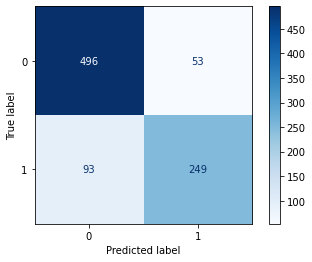

In [51]:
disp = plot_confusion_matrix(logreg, data_kaggle, y,
                             cmap=plt.cm.Blues,
                             normalize=None)

In [52]:
import statsmodels.api as sm
logit_model=sm.Logit(y,data_kaggle.drop(["SibSp"],axis=1))
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.405902
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      880
Method:                           MLE   Df Model:                           10
Date:                Fri, 05 Mar 2021   Pseudo R-squ.:                  0.3905
Time:                        15:14:29   Log-Likelihood:                -361.66
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 2.981e-93
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Pclass             -0.9716      0.177     -5.482      0.000      -1.319      -0.624
Sex           

In [ ]:
y_pred=clf_cv.predict(test)

In [ ]:
submission_knn = pd.DataFrame({'PassengerId':test.index,'Survived':y_pred})
submission_knn.to_csv("res_knn.csv",index=False)

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.79 \leq score < 0.81,$$
$$ f(score) = 1.0, \ \ 0.81 \leq score < 0.83,$$ 
$$ f(score) = 2.5, \ \ 0.83 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [54]:
insurance_data = pd.read_csv( './porto-seguro-safe-driver-prediction/train.csv').set_index('id')

In [55]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [56]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [57]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [58]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [59]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [60]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

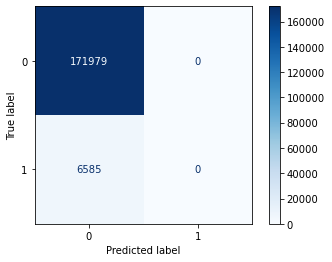

In [61]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [62]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

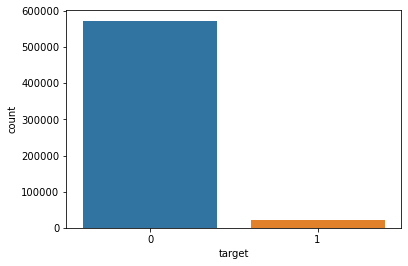

In [63]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [64]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

Gini  is the ratio of the area between your curve and the diagonal and the area between the perfect model and the diagonal.  If you use it on the ROC curve then you see the relation to the AUC. The perfect model in the ROC is just a straight line (0% FPR 
Gini= A/(A+B),  
A+B=0.5, 
Then Gini=2*A

AUC=A+0.5 , then
    Gini=2*AUC-1

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

Я бы посмотрела на метрики Sensitivity = TruePositive / (TruePositive + FalseNegative) и Specificity = TrueNegative / (FalsePositive + TrueNegative),Confusion matrix and ROC-AUC Score ,F_measure 

Let's calculate the Normalized Gini Coefficient:

In [65]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [66]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

### Проверим  регрессию c class_weight='balanced

In [67]:
from sklearn.linear_model import LogisticRegression

In [68]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14,class_weight='balanced'))]).fit(X_train,y_train)

In [69]:
y_pred=pipeline.predict(X_valid)

In [70]:
accuracy_score(y_true=y_valid, y_pred=y_pred)

0.45958871889070585

In [71]:
gini_normalized(y_valid, y_pred)

0.16269527228971548

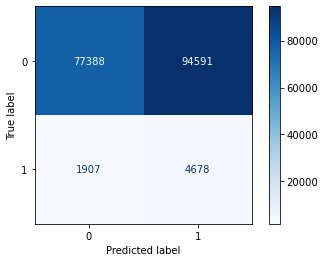

In [72]:
disp = plot_confusion_matrix(pipeline, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

### Подбор весовых коэффициентов 

In [73]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [74]:
X_train_new=preprocessor.fit_transform(X_train)

In [75]:
from sklearn.model_selection import GridSearchCV

weights=np.linspace(0.05,0.95,20)
gsc = GridSearchCV(
    estimator=SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=3
)
grid_result = gsc.fit(X_train_new,y_train)

print("Best parameters : %s" % grid_result.best_params_)


Best parameters : {'class_weight': {0: 0.05, 1: 0.95}}


In [76]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14,class_weight={0: 0.05, 1: 0.95}))]).fit(X_train,y_train)

In [77]:
y_pred=pipeline.predict(X_valid)
accuracy_score(y_true=y_valid, y_pred=y_pred)

0.8428350619385766

In [78]:
gini_normalized(y_valid, y_pred)

0.1362966650499761

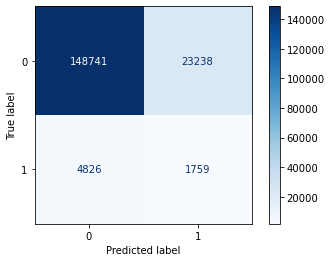

In [93]:
disp = plot_confusion_matrix(pipeline, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

In [92]:
test = pd.read_csv( './porto-seguro-safe-driver-prediction/test.csv').set_index('id')
res_test=pipeline.predict(test)
submission_driver = pd.DataFrame({'id':test.index,'target':res_test})
submission_driver.to_csv("driver.csv",index=False)

### Under-sampling

In [132]:
insurance_data["target"].value_counts()

0    573518
1     21694
Name: target, dtype: int64

In [136]:
class_0 = insurance_data[insurance_data['target'] == 0]
class_1 = insurance_data[insurance_data['target'] == 1]
train_under=pd.concat([class_0.sample(21694),class_1])

In [139]:
train_under["target"].value_counts()

1    21694
0    21694
Name: target, dtype: int64

In [141]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [146]:
estimator=pipeline.fit(train_under.drop(["target"],axis=1),train_under["target"])

In [147]:
test = pd.read_csv( './porto-seguro-safe-driver-prediction/test.csv').set_index('id')
res_test=pipeline.predict(test)
submission_driver = pd.DataFrame({'id':test.index,'target':res_test})
submission_driver.to_csv("train_under.csv",index=False)

# Over-sampling

In [140]:
train_over = pd.concat([class_0, class_1.sample(573518, replace=True)], axis=0)
train_over["target"].value_counts()

1    573518
0    573518
Name: target, dtype: int64

In [149]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])
estimator=pipeline.fit(train_over.drop(["target"],axis=1),train_over["target"])

In [150]:
res_test=pipeline.predict(test)
submission_driver = pd.DataFrame({'id':test.index,'target':res_test})
submission_driver.to_csv("train_over.csv",index=False)